In [1]:
from model import FFNet
from learning import Learn, Selector
from dataset import SKDS, TVDS

from torch.optim import Adam
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

<class 'dataset.SKDS'> dataset created...
epoch: 0 of 100, train loss: 13724.047095514114, val loss: 2271.912353515625, lr: 0.01
epoch: 10 of 100, train loss: 902.1932491179435, val loss: 922.765380859375, lr: 0.01
epoch: 20 of 100, train loss: 884.179446312689, val loss: 1292.453857421875, lr: 0.001
epoch: 30 of 100, train loss: 785.4343763782132, val loss: 925.4710083007812, lr: 0.001
epoch: 40 of 100, train loss: 731.1211941626764, val loss: 570.7907206217448, lr: 0.0001
epoch: 50 of 100, train loss: 745.7447125834804, val loss: 817.5417073567709, lr: 0.0001
epoch: 60 of 100, train loss: 697.4644155194683, val loss: 929.3701375325521, lr: 1e-05
epoch: 70 of 100, train loss: 638.7241653934602, val loss: 919.3416137695312, lr: 1.0000000000000002e-06
epoch: 80 of 100, train loss: 784.0717674993699, val loss: 636.8257039388021, lr: 1.0000000000000002e-07
epoch: 90 of 100, train loss: 740.1982874716482, val loss: 791.9921671549479, lr: 1.0000000000000004e-08
test loss: 625.4869486490885


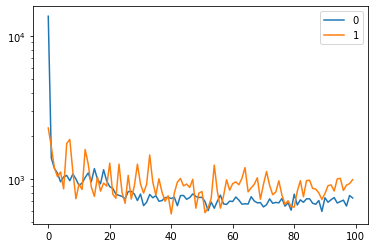

learning time: 0:00:52.175633


In [2]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'make': 'make_regression',
             'make_params': {'n_samples': 10000,
                             'n_features': 128}}

opt_params = {'lr': 0.01}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}
sched_params = {'factor': .1,
                'patience': 10}

l = Learn(SKDS, FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=100)

In [19]:
tvds = TVDS('MNIST', ds_params={'root': './data/',
                                'download': True})

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [20]:
tvds[1]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F71386FBA90>, 0)

In [21]:
tvds[2][0]